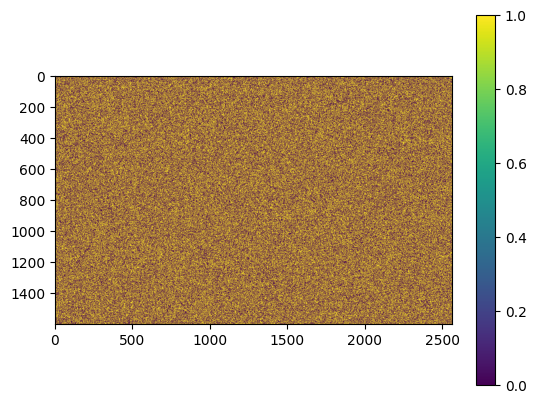

True

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def load (filename):
    mask = torch.load(filename,weights_only=False)
    for m, b in mask.named_parameters():
        return b
    
def load_convert (filename):
    mask = load(filename)
    mask = mask - mask.logsumexp(-1, keepdim=True)
    probs = torch.softmax(mask, -1)
    mask = probs.max(dim=-1, keepdim=True)[1]
    mask = mask.squeeze()

    # Upscale mask [H, W] to [2H, 2W]
    mask = mask.unsqueeze(0).unsqueeze(0)
    mask = mask.repeat_interleave(2, -2).repeat_interleave(2, -1)
    mask = mask.squeeze()


    logical_masks = torch.tensor([
    [[1, 0], [1, 0]],  # 0
    [[1, 0], [0, 0]],  # 1
    [[0, 0], [1, 0]],  # 2
    [[1, 0], [1, 1]],  # 3
    [[0, 0], [0, 0]],  # 4
    [[1, 0], [0, 1]],  # 5
    [[0, 0], [1, 1]],  # 6
    [[0, 0], [0, 1]],  # 7
    [[1, 1], [1, 0]],  # 8
    [[1, 1], [0, 0]],  # 9
    [[0, 1], [1, 0]],  #10
    [[0, 1], [0, 0]],  #11
    [[1, 1], [1, 1]],  #12
    [[1, 1], [0, 1]],  #13
    [[0, 1], [1, 1]],  #14
    [[0, 1], [0, 1]]   #15
    ], dtype=torch.uint8)

    H, W = mask.shape[0], mask.shape[1]
    logical = logical_masks.index_select(0, mask.view(-1))
    logical = logical.view(1, H, W, 2, 2)
    logical = logical.permute(0, 1, 3, 2, 4).contiguous()
    encoded = logical.view(1, H * 2, W * 2)
    encoded = encoded.squeeze(0)
    encoded = torch.fliplr(encoded)
    return encoded

mask = load_convert('2025_10_22/2025_10_22_001/epoch_2/mask.pt')
mask = mask.numpy()

# Mask is shaped as [H, W, n_classes] for n_classes = logits
plt.imshow(mask, cmap='viridis')
plt.colorbar()
plt.show()

# save mask as
cv2.imwrite('mask3.bmp', mask * (255 // mask.max()))


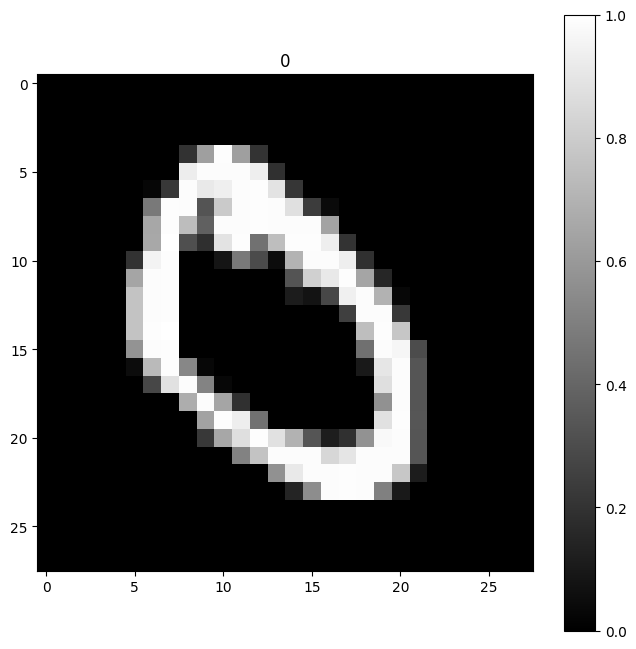

In [37]:
X=np.load('Datasets/Images/Training_Dataset.npy')
Y=np.load('Datasets/Labels/Training_Dataset.npy')

plt.figure(figsize=(8,8))
plt.imshow(np.squeeze(X[1]),cmap='gray')
plt.colorbar()
plt.title(f'{np.argmax(Y[1])}')
plt.show()

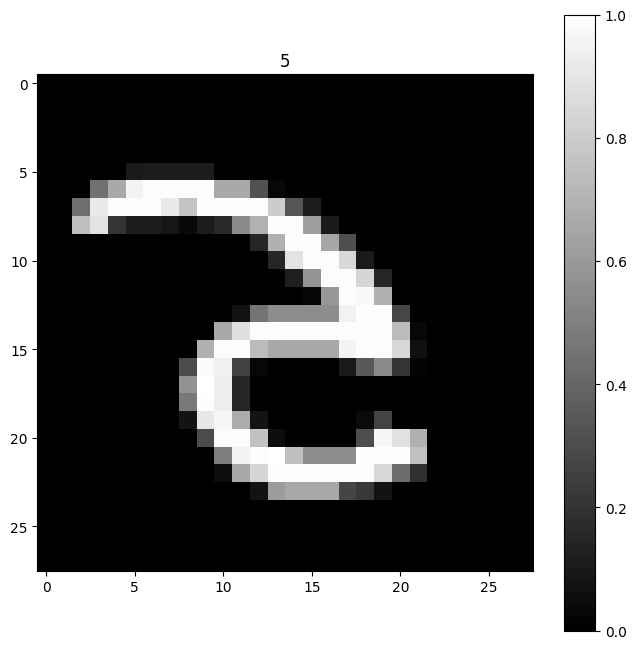

In [36]:
X=np.load('Datasets/Images/Validation_Dataset.npy')
Y=np.load('Datasets/Labels/Validation_Dataset.npy')

plt.figure(figsize=(8,8))
plt.imshow(np.squeeze(X[1]),cmap='gray')
plt.colorbar()
plt.title(f'{np.argmax(Y[1])}')
plt.show()

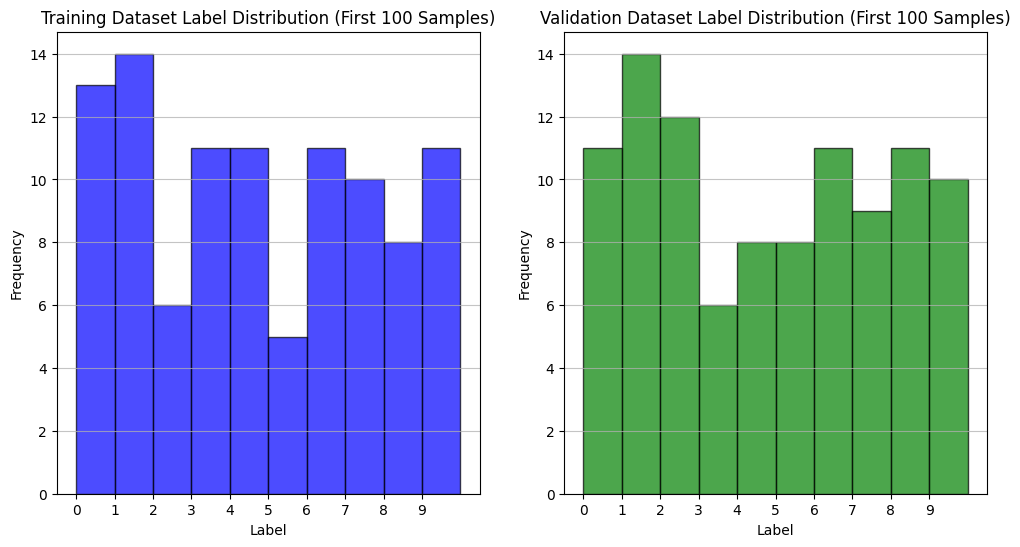

In [42]:
# Find the distribution of the first 100 labels for Training and Validation
import matplotlib.pyplot as plt
import numpy as np

YT = np.squeeze(np.load('Datasets/Labels/Training_Dataset.npy'))
YV = np.squeeze(np.load('Datasets/Labels/Validation_Dataset.npy'))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(np.argmax(YT[:100], axis=1), bins=10, range=(0,10), alpha=0.7, color='blue', edgecolor='black')
plt.title('Training Dataset Label Distribution (First 100 Samples)')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.75)
plt.subplot(1,2,2)
plt.hist(np.argmax(YV[:100], axis=1), bins=10, range=(0,10), alpha=0.7, color='green', edgecolor='black')
plt.title('Validation Dataset Label Distribution (First 100 Samples)')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.75)
plt.show()


In [54]:
# Extract 2 balanced datasets with 10 samples per class from the
# Training Dataset
import numpy as np
X = np.load('Datasets/Images/Training_Dataset.npy')
Y = np.squeeze(np.load('Datasets/Labels/Training_Dataset.npy'))
X_balanced_1 = []
Y_balanced_1 = []
X_balanced_2 = []
Y_balanced_2 = []
class_counts = {i: 0 for i in range(10)}
class_counts_2 = {i: 0 for i in range(10)}
for i in range(len(Y)):
    label = np.argmax(Y[i])
    if class_counts[label] < 10:
        X_balanced_1.append(X[i])
        Y_balanced_1.append(Y[i])
        class_counts[label] += 1
    if all(count >= 10 for count in class_counts.values()):
        # Do the second balanced dataset
        if class_counts_2[label] < 10:
            X_balanced_2.append(X[i])
            Y_balanced_2.append(Y[i])
            class_counts_2[label] += 1
    if all(count >= 10 for count in class_counts_2.values()):
        break
X_balanced_1 = np.array(X_balanced_1)
Y_balanced_1 = np.array(Y_balanced_1)
X_balanced_2 = np.array(X_balanced_2)
Y_balanced_2 = np.array(Y_balanced_2)

np.save('Datasets/Images/Balanced_1.npy', X_balanced_1)
np.save('Datasets/Labels/Balanced_1.npy', np.expand_dims(Y_balanced_1, axis=1))
np.save('Datasets/Images/Balanced_2.npy', X_balanced_2)
np.save('Datasets/Labels/Balanced_2.npy', np.expand_dims(Y_balanced_2, axis=1))


In [90]:
## Get files list from dir
import os
files = os.listdir('./export_val')

# first sort files by index
files.sort(key=lambda x: int(x.split('_')[0]))

# files are organized as <index>_<label>_p<prediction>.png
labels = []
preds = []
for i, f in enumerate(files):
    parts = f.split('_')
    label = int(parts[1])
    pred = int(parts[2][1:-4])  # remove 'p' and '.png'
    if i < 10:
        print(f, label, pred)
    labels.append(label)
    preds.append(pred)

# Calculate accuracy
correct = sum(1 for l, p in zip(labels, preds) if l == p)
total = len(labels)
accuracy = correct / total * 100
print(f'Accuracy: {accuracy:.2f}% ({correct}/{total})')

0_5_p0.png 5 0
1_0_p1.png 0 1
2_7_p1.png 7 1
3_1_p8.png 1 8
4_8_p7.png 8 7
5_5_p1.png 5 1
6_0_p0.png 0 0
7_2_p1.png 2 1
8_6_p4.png 6 4
9_7_p1.png 7 1
Accuracy: 12.00% (12/100)


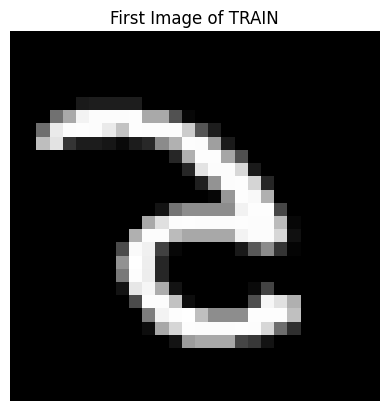

In [88]:
# Print first image of TRAIN
import matplotlib.pyplot as plt
X = np.load('Datasets/Images/Validation_Dataset.npy')
plt.imshow(np.squeeze(X[1]), cmap='gray')
plt.title('First Image of TRAIN')
plt.axis('off')
plt.show()

In [26]:
mask = load('2025_10_22/2025_10_22_001/epoch_2/mask.pt')
maskA = mask - mask.logsumexp(-1, keepdim=True)
probs = torch.softmax(maskA, -1)
maskA = probs.max(dim=-1, keepdim=True)[1]
maskA = maskA.squeeze()

maskB = mask.argmax(dim=-1)

(maskA == maskB).sum() == maskA.numel()


tensor(True)